# Impact of fault zones on production - Karnes Trough

In [20]:
import warnings

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from scipy import optimize
from bayes_opt import BayesianOptimization
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap
from shapash.explainer.smart_explainer import SmartExplainer

sns.set(context="talk")
fig_dir = "figures/"

In [2]:
df = (
    pd.read_parquet("austin_chalk_ml_vars.parquet")
    .dropna(subset=["Fault length"])
    .assign(min_dist=lambda x: x.min_dist.fillna(2.6e3))[
        lambda x: x.start_date.dt.year >= 2010
    ]
    .rename(columns=lambda x: x.replace(" ", "_"))
)

In [3]:
rename = {
    "gravity": "Oil gravity",
    #'water_cut':'Water cut',
    "gor": "First year gas-oil ratio",
    "length_lateral": "Lateral length",
    "min_dist": "Distance to nearest well",
    "prop_per_length_c": "Proppant per length",
    "fluid_per_length_c": "Frack fluid per length",
    "stages_number": "Number of stages",
    "Distance_to_nearest_fault": "Distance to nearest fault",
    "Fault_length": "Fault length",
    "bearing": "Fault bearing",
    "sinuosity": "Fault sinuosity",
}
X_cols = [
    "gravity",
    #'water_cut',
    "gor",
    "length_lateral",
    "min_dist",
    "prop_per_length_c",
    "fluid_per_length_c",
    "stages_number",
    "Distance_to_nearest_fault",
    "Fault_length",
    "bearing",
    "sinuosity",
]

In [4]:
y = df.liquids_eur_length.pipe(np.log)
X = df.loc[y.index, X_cols].fillna(-1)  # .rename(columns=rename)

In [5]:
X[X == -1].sum()

gravity                     -11.0
gor                           0.0
length_lateral                0.0
min_dist                      0.0
prop_per_length_c           -10.0
fluid_per_length_c          -10.0
stages_number               -29.0
Distance_to_nearest_fault     0.0
Fault_length                  0.0
bearing                       0.0
sinuosity                     0.0
dtype: float64

In [6]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
baseline_mae = mean_absolute_error(y_train, np.ones(y_train.shape) * np.mean(y_train))
print(f"Baseline MAE is {baseline_mae:.2f}")

Baseline MAE is 0.62


In [7]:
y_train.describe(), y_train.shape

(count    178.000000
 mean       4.233329
 std        0.867242
 min        0.077539
 25%        3.830370
 50%        4.353856
 75%        4.769215
 max        5.526794
 Name: liquids_eur_length, dtype: float64,
 (178,))

In [8]:
test_params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
    "num_leaves": 4,
    "max_depth": 10,
    #'min_data_in_leaf':10,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": 1,
}
reg = lgb.train(test_params, lgb_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 398
[LightGBM] [Info] Number of data points in the train set: 178, number of used features: 11
[LightGBM] [Info] Start training from score 4.233329


MAE: 0.4905543515762308 
MSE: 0.6734243151659286 
R2: 0.37940666370843623


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

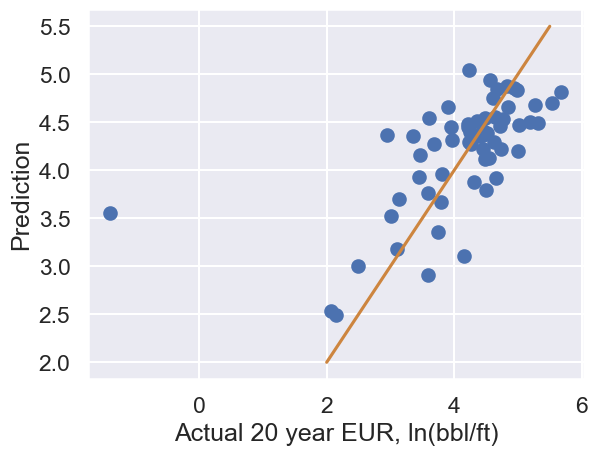

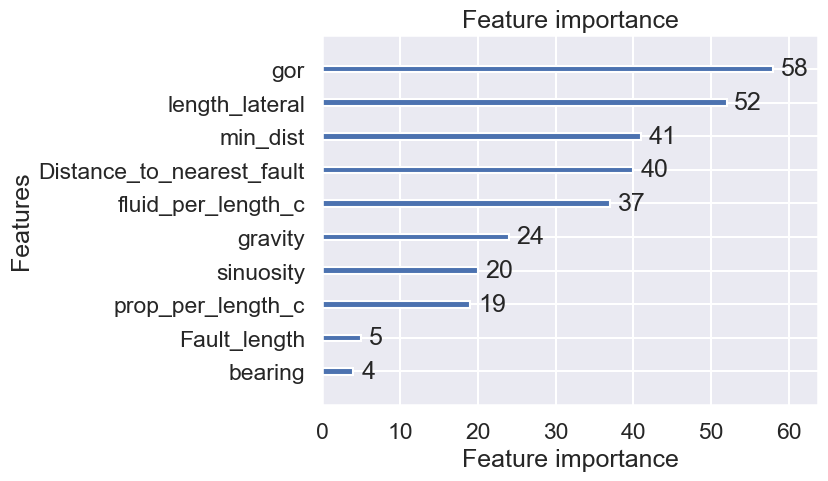

In [9]:
y_pred = reg.predict(X_test)
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([2, 5.5], [2, 5.5], color="peru")
ax.set(xlabel="Actual 20 year EUR, ln(bbl/ft)", ylabel="Prediction")
print(
    "MAE:",
    mean_absolute_error(y_test, y_pred),
    "\nMSE:",
    mean_squared_error(y_test, y_pred),
    "\nR2:",
    r2_score(y_test, y_pred),
)
lgb.plot_importance(reg)

In [10]:
explainer = shap.TreeExplainer(reg, X_test)
shap_contrib = explainer.shap_values(X_test)

In [11]:
xpl = SmartExplainer(features_dict=rename, model=reg)

xpl.compile(
    x=X_test,
    contributions=shap_contrib,
    y_pred=pd.Series(y_pred, index=X_test.index),
)

In [12]:
# xpl.plot.local_plot(index=10)
#app = xpl.run_app()

In [13]:
def lgb_cv(
    max_depth, gamma, min_child_weight, max_delta_step, subsample, colsample_bytree
):
    paramt = {
        "max_depth": int(max_depth),
        "gamma": gamma,
        "eta": 0.05,
        "objective": "rmse",
        "nthread": 4,
        "eval_metric": "rmse",
        "subsample": max(min(subsample, 1), 0),
        "colsample_bytree": max(min(colsample_bytree, 1), 0),
        "min_child_weight": min_child_weight,
        "max_delta_step": int(max_delta_step),
        "seed": 1001,
    }

    rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=342)
    lgbc = lgb.cv(
        paramt,
        lgb_train,
        num_boost_round=2000,
        folds=rkf,
        early_stopping_rounds=100,
        metrics="rmse",
        show_stdv=True,
    )

    val_score = lgbc["test-rmse-mean"].iloc[-1]
    train_score = lgbc["train-rmse-mean"].iloc[-1]
    print(
        f" Stopped after {len(lgbc)} iterations with train = {train_score:.2f} val = {val_score:.2f}"
        f" ( diff = {train_score - val_score:.2f} )"
    )

    return -val_score

In [14]:
def clean_params(
    num_leaves,
    feature_fraction,
    bagging_fraction,
    max_depth,
    lambda_l1,
    lambda_l2,
    min_split_gain,
    min_child_weight,
):
    params = {
        "application": "regression",
        "num_iterations": 4000,
        "learning_rate": 0.05,
        "early_stopping_round": 100,
        "metric": "rmse",
    }
    params["num_leaves"] = round(num_leaves)
    params["feature_fraction"] = max(min(feature_fraction, 1), 0)
    params["bagging_fraction"] = max(min(bagging_fraction, 1), 0)
    params["max_depth"] = round(max_depth)
    params["lambda_l1"] = max(lambda_l1, 0)
    params["lambda_l2"] = max(lambda_l2, 0)
    params["min_split_gain"] = min_split_gain
    params["min_child_weight"] = min_child_weight
    return params


def lgb_eval(
    num_leaves,
    feature_fraction,
    bagging_fraction,
    max_depth,
    lambda_l1,
    lambda_l2,
    min_split_gain,
    min_child_weight,
):
    params = clean_params(
        num_leaves,
        feature_fraction,
        bagging_fraction,
        max_depth,
        lambda_l1,
        lambda_l2,
        min_split_gain,
        min_child_weight,
    )
    rkf = RepeatedKFold(n_splits=5, n_repeats=5, random_state=342)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        result = lgb.cv(params, lgb_train, folds=rkf, metrics="rmse")
    return -min(result["valid rmse-mean"])

In [ ]:
LGB_BO = BayesianOptimization(
    lgb_eval,
    {
        "num_leaves": (4, 50),
        "feature_fraction": (0.1, 1.0),
        "bagging_fraction": (0.6, 1.0),
        "max_depth": (2, 12),
        "lambda_l1": (0, 5),
        "lambda_l2": (0, 5),
        "min_split_gain": (0.001, 0.1),
        "min_child_weight": (0, 20),
    },
    random_state=42,
)

LGB_BO.maximize(init_points=50, n_iter=30)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 398
[LightGBM] [Info] Number of data points in the train set: 142, number of used features: 11
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 398
[LightGBM] [Info] Number of data points in the train set: 142, number of used features: 11
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Tota

In [ ]:
LGB_BO.max

In [21]:
best_params = {
    'application': 'regression',
 'num_iterations': 4000,
 'learning_rate': 0.05,
 'early_stopping_round': 100,
 'metric': 'rmse',
 'num_leaves': 12,
 'feature_fraction': 0.9152855179978466,
 'bagging_fraction': 0.7947503632992209,
 'max_depth': 8,
 'lambda_l1': 0.16722037866054473,
 'lambda_l2': 1.3191467850945378,
 'min_split_gain': 0.09832114261117764,
 'min_child_weight': 0.12411506194048849
}

In [22]:
clean_params(**LGB_BO.max["params"])

{'application': 'regression',
 'num_iterations': 4000,
 'learning_rate': 0.05,
 'early_stopping_round': 100,
 'metric': 'rmse',
 'num_leaves': 30,
 'feature_fraction': np.float64(0.9771974311893218),
 'bagging_fraction': np.float64(0.8903025830034057),
 'max_depth': 11,
 'lambda_l1': np.float64(0.38623764815687855),
 'lambda_l2': np.float64(2.3237711857505956),
 'min_split_gain': np.float64(0.08042939365260533),
 'min_child_weight': np.float64(6.381767295338316)}

In [24]:
best_params = clean_params(**LGB_BO.max["params"])
best_params.pop("early_stopping_round")
reg_cvd = lgb.train(best_params, lgb_train)

/home/frank/Dropbox/Austin-chalk-faults/.venv/lib/python3.12/site-packages/lightgbm/engine.py:204: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 398
[LightGBM] [Info] Number of data points in the train set: 178, number of used features: 11
[LightGBM] [Info] Start training from score 4.233329
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

MAE: 0.5020157253031872 
MSE: 0.65925784659473 
R2: 0.3924617551212011


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

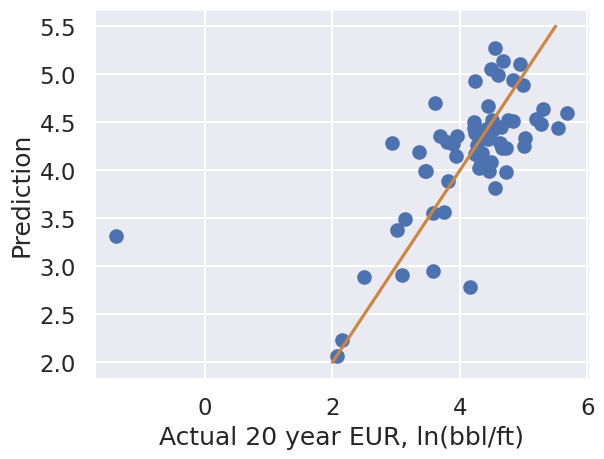

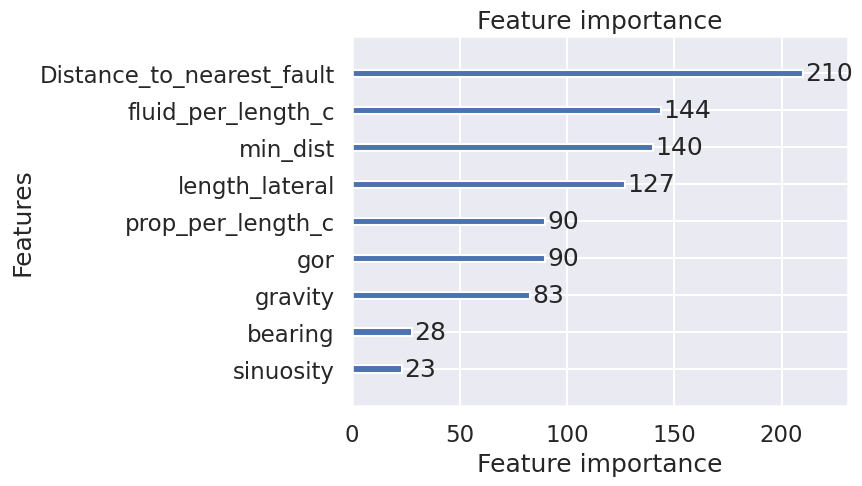

In [25]:
y_pred = reg_cvd.predict(X_test)
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([2, 5.5], [2, 5.5], color="peru")
ax.set(xlabel="Actual 20 year EUR, ln(bbl/ft)", ylabel="Prediction")
print(
    "MAE:",
    mean_absolute_error(y_test, y_pred),
    "\nMSE:",
    mean_squared_error(y_test, y_pred),
    "\nR2:",
    r2_score(y_test, y_pred),
)
lgb.plot_importance(reg_cvd)

In [26]:
LGB_BO.max

{'target': np.float64(-0.6608121579313273),
 'params': {'bagging_fraction': np.float64(0.8903025830034057),
  'feature_fraction': np.float64(0.9771974311893218),
  'lambda_l1': np.float64(0.38623764815687855),
  'lambda_l2': np.float64(2.3237711857505956),
  'max_depth': np.float64(10.993702712095288),
  'min_child_weight': np.float64(6.381767295338316),
  'min_split_gain': np.float64(0.08042939365260533),
  'num_leaves': np.float64(29.84007082381013)}}

In [27]:
test_preds = reg_cvd.predict(X_test)
train_preds = reg_cvd.predict(X_train)

print(
    f"MAE train: {mean_absolute_error(train_preds, y_train):.2f}",
)
print(f"MAE test: {mean_absolute_error(test_preds, y_test):.2f}")

print(
    f"R2 train: {np.corrcoef(train_preds, y_train)[0,1] **2:.2f}",
)
print(f"R2 test: {np.corrcoef(test_preds, y_test)[0,1] **2:.2f}")

MAE train: 0.26
MAE test: 0.50
R2 train: 0.82
R2 test: 0.39


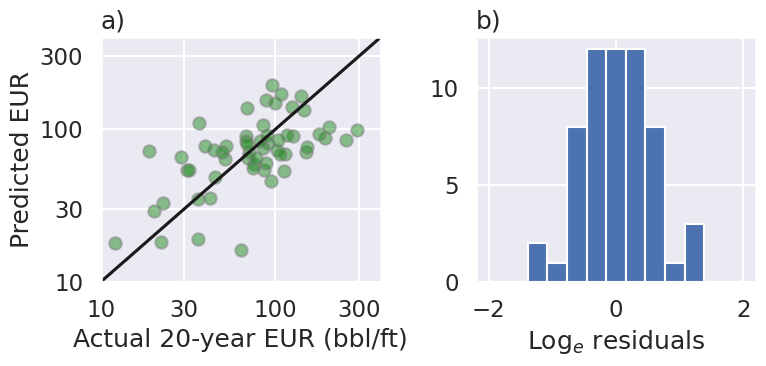

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
lims = [10, 400]
ax1.plot(lims, lims, "k-")
ax1.scatter(
    np.exp(y_test),
    np.exp(test_preds),
    color="forestgreen",
    alpha=0.5,
    edgecolors="gray",
)

ax1.set(
    xlabel="Actual 20-year EUR (bbl/ft)",
    xlim=lims,
    xscale="log",
    ylabel="Predicted EUR",
    ylim=lims,
    yscale="log",
)
ax1.set_title("a)", loc="left")

tickmarks = [10, 30, 100, 300]
ax1.set_xticks(tickmarks)
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_yticks(tickmarks)
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.hist(y_test - test_preds, bins=np.linspace(-2, 2, 14))
ax2.set(xlabel="Log$_e$ residuals")
ax2.set_title("b)", loc="left")

fig.tight_layout()
fig.savefig(fig_dir + "lgb_fault_comparison.png", dpi=400, bbox_inches="tight")

# SHAP

In [29]:
reg_cvd.params["objective"] = "regression"
explainer = shap.TreeExplainer(reg_cvd)
shap_values = explainer.shap_values(X_test)

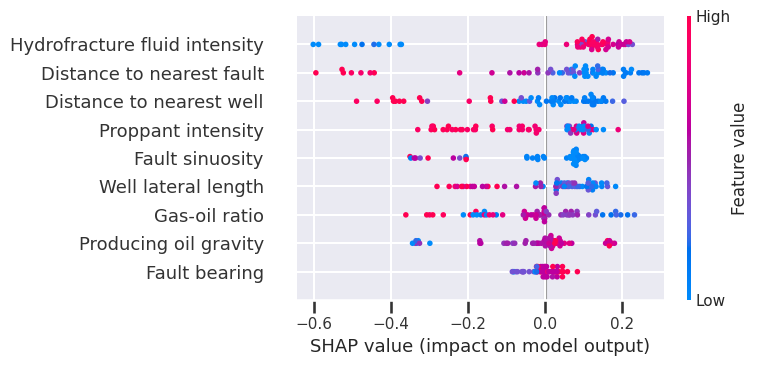

In [30]:
shap_values_df = pd.DataFrame(shap_values, columns=X_test.columns, index=X_test.index)
col_rename = {
    "fluid_per_length_c": "Hydrofracture fluid intensity",
    "Distance_to_nearest_fault": "Distance to nearest fault",
    "min_dist": "Distance to nearest well",
    "prop_per_length_c": "Proppant intensity",
    "gor": "Gas-oil ratio",
    "sinuosity": "Fault sinuosity",
    "length_lateral": "Well lateral length",
    "gravity": "Producing oil gravity",
    "bearing": "Fault bearing",
    "Fault_length": "Fault length",
    "stages_number": "Number of HF stages",
}
drop_cols = ["Fault_length", "stages_number"]

shap.summary_plot(
    shap_values_df.drop(columns=drop_cols).values,
    X_test.drop(columns=drop_cols).rename(columns=col_rename),
    show=False,
    plot_size=(8, 4),
)
fig = plt.gcf()
ax = plt.gca()
fig.savefig(fig_dir + "SHAP_values_faults.png", dpi=500, bbox_inches="tight")

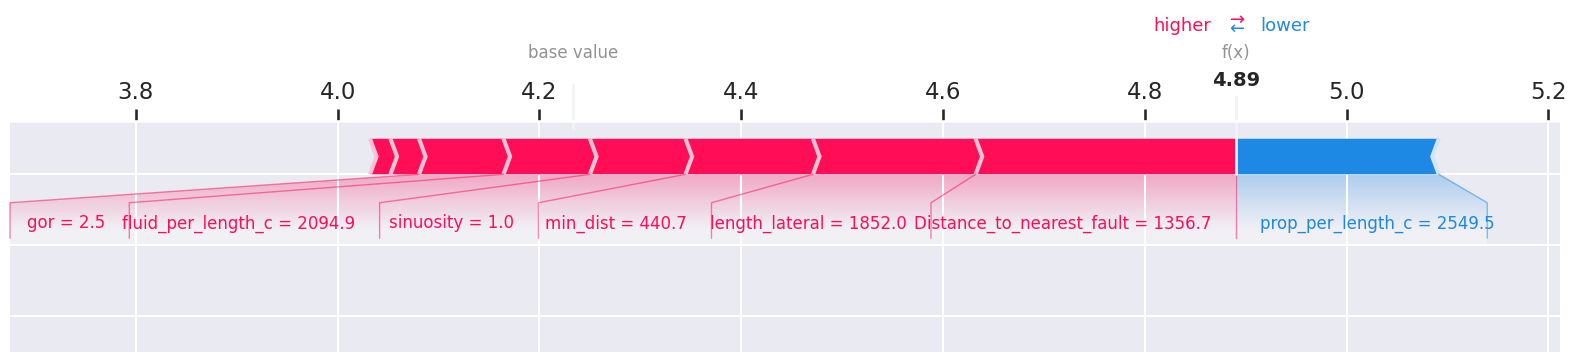

In [31]:
# i = 46
i = 22
shap.force_plot(
    explainer.expected_value,
    shap_values[i, :],
    X_train.iloc[i, :].apply(lambda x: round(x, 1)),
    matplotlib=True,
)

In [ ]:
from shapash.explainer.smart_explainer import SmartExplainer

xpl = SmartExplainer()

xpl.compile(
    contributions=shap_values_df,
    x=X_test,
    model=reg_cvd,
)

In [32]:
shap_values.sum(1).argsort()

array([23, 42, 19, 46,  6,  1, 24, 33, 45, 12, 16, 13,  4, 53, 35,  8,  2,
       18, 14, 59, 31,  5, 34, 52, 56, 38, 55, 21, 58, 50, 20, 36, 26, 57,
       54, 10, 37,  0, 39, 25,  9,  3, 41, 11, 40, 47, 44, 48,  7, 51, 28,
       17, 22, 27, 49, 32, 30, 43, 15, 29])

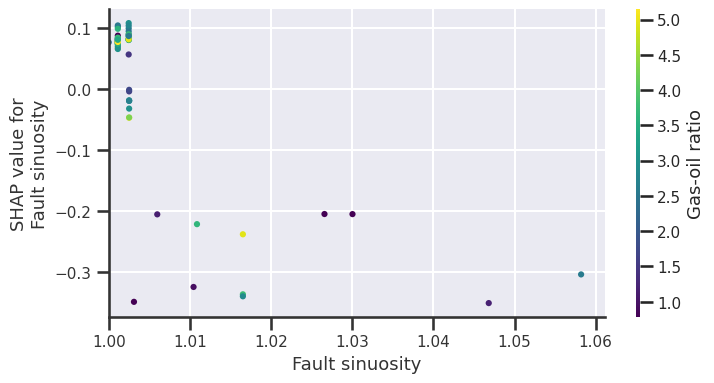

In [33]:
fig, ax = plt.subplots(figsize=(8, 4))
shap.dependence_plot(
    "Fault sinuosity",
    shap_values,
    X_test.rename(columns=col_rename),
    show=False,
    cmap="viridis",
    dot_size=20,
    ax=ax,
)
ax.set(xlim=(1, None))
plt.savefig(fig_dir + "SHAP_values_sinuosity.png", dpi=500, bbox_inches="tight")

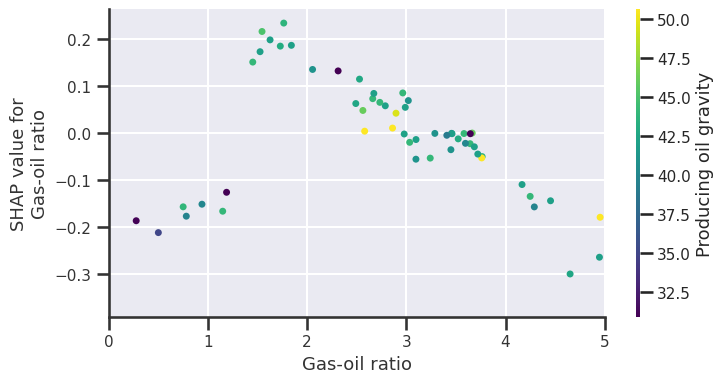

In [34]:
fig, ax = plt.subplots(figsize=(8, 4))
shap.dependence_plot(
    "Gas-oil ratio",
    shap_values,
    X_test.rename(columns=col_rename),
    show=False,
    interaction_index="Producing oil gravity",
    cmap="viridis",
    dot_size=25,
    ax=ax,
)
ax.set(xlim=(0, 5))
plt.savefig(fig_dir + "SHAP_values_GOR.png", dpi=500, bbox_inches="tight")

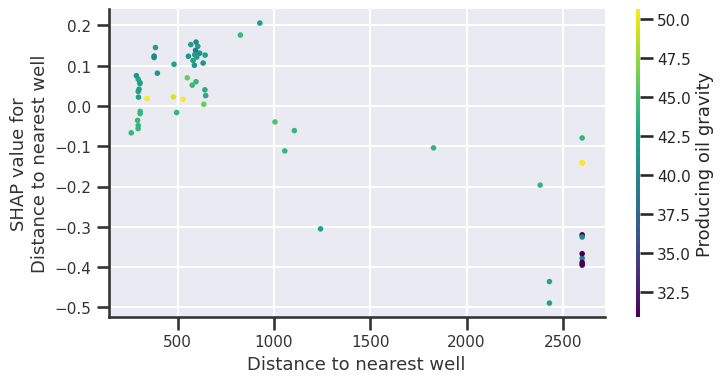

In [35]:
fig, ax = plt.subplots(figsize=(8, 4))
shap.dependence_plot(
    "Distance to nearest well",
    shap_values,
    X_test.rename(columns=col_rename),
    show=False,
    cmap="viridis",
    ax=ax,
)
# ax.set(xlim=(0, 5))
# plt.savefig(fig_dir + 'SHAP_values_GOR.png', dpi=500, bbox_inches='tight')

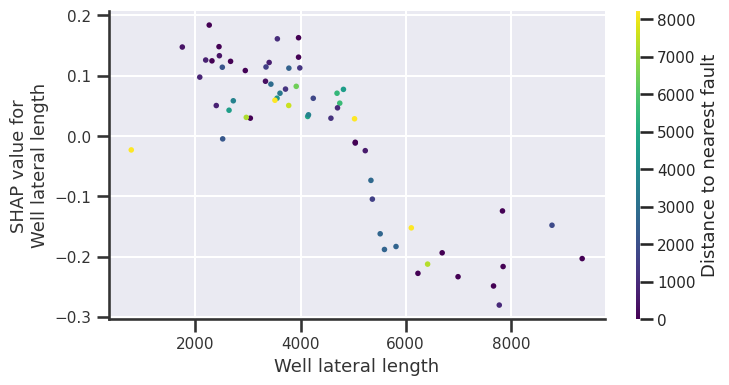

In [36]:
fig, ax = plt.subplots(figsize=(8, 4))
shap.dependence_plot(
    "Well lateral length",
    shap_values,
    X_test.rename(columns=col_rename),
    show=False,
    cmap="viridis",
    ax=ax,
)
# ax.set(xlim=(0, 5))
# plt.savefig(fig_dir + 'SHAP_values_GOR.png', dpi=500, bbox_inches='tight')

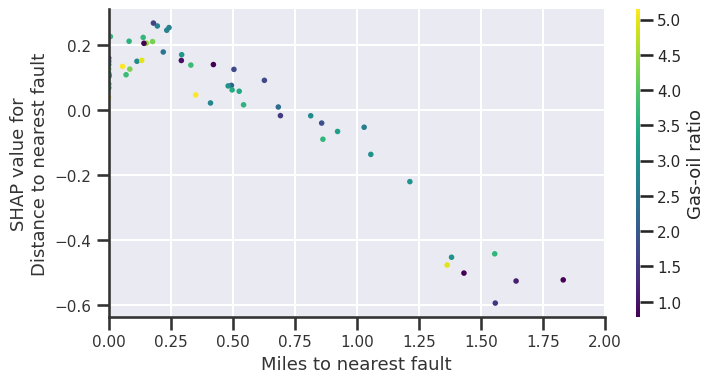

In [37]:
fig, ax = plt.subplots(figsize=(8, 4))
shap.dependence_plot(
    "Distance to nearest fault",
    shap_values,
    X_test.rename(columns=col_rename).assign(
        **{"Distance to nearest fault": lambda x: x["Distance to nearest fault"] / 5280}
    ),
    show=False,
    cmap="viridis",
    ax=ax,
)
ax.set(xlim=(0, 2), xlabel="Miles to nearest fault")
plt.savefig(fig_dir + "SHAP_values_Fault distance.png", dpi=500, bbox_inches="tight")